## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

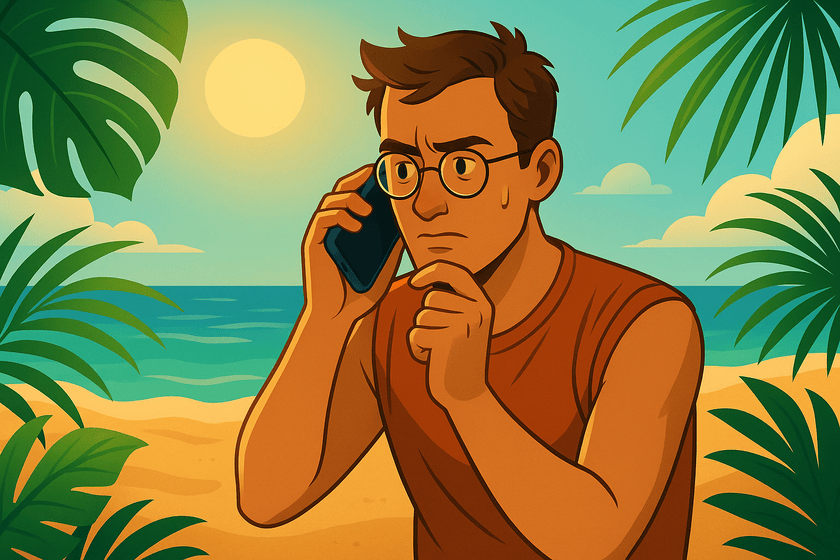

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

2025-08-24 20:29:00.165231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


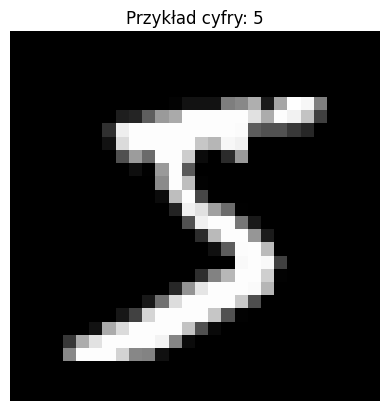

In [1]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

In [2]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Pobiera zbiór MNIST (28×28, skala 0–255, dtype=uint8)<br>
Zwraca cztery tablice NumPy:

- x_train: (60000, 28, 28)

- y_train: (60000)

- x_test: (10000, 28, 28)

- y_test: (10000)

# Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?

Poprzednie zadanie nauczyło mnie lepszego obchodzenia się z bazą danych, podziału jej, oraz dobierania odpowiednich parametrów do modelu. Uświadomiło mnie również, że przed podziałem zbioru trzeba zastanowić się nad tym, w jakich procentach go podzielić i podział 60:20:20 nie jest najlepszy w przypadku małych zbiorów. Nauczyłem się również że są takie funkcje, jak sklearn.impute.SimpleImputer oraz sklearn.preprocessing.OrdinalEncoder do uzupełniania danych. Dowiedziałem się również, że modele potrafią się zupełnie odmienię zachowywać dla nadanych im parametrów i potrafią występować skoki. Jeszcze o czym zapomniałem, to że różne modele różnie radzą sobie z podanymi danymi, niektóre lepiej niektóre gorzej. A i na koniec jeszcze, żeby nie robić sraki na wykresie 

### Ustawienie CPU jako jednostki na której nasz model będzie się uczył

bo moje GPU nie jest w pełni wspierane

In [3]:
import torch
device = torch.device("cpu")
print(device)


cpu


### Ustawienie seeda 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random

SEED = 69 
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



I owczywiście tutaj problem bo python 3.13.6 jest zbyt nowy dla torchvision

# Normalizacja danych

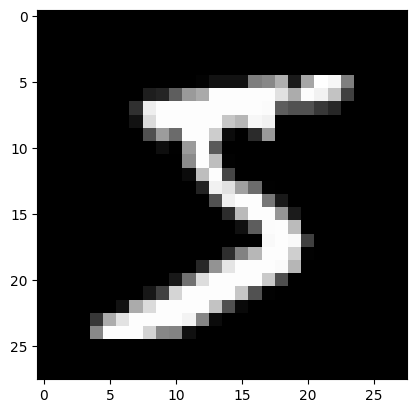

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [5]:
plt.imshow(x_train[0], cmap='gray')
plt.show()
print(x_train[0])

In [6]:
x_train_py = torch.FloatTensor(x_train) / 255.0
x_test_py = torch.FloatTensor(x_test) / 255.0
y_train_py = torch.LongTensor(y_train)
y_test_py = torch.LongTensor(y_test)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

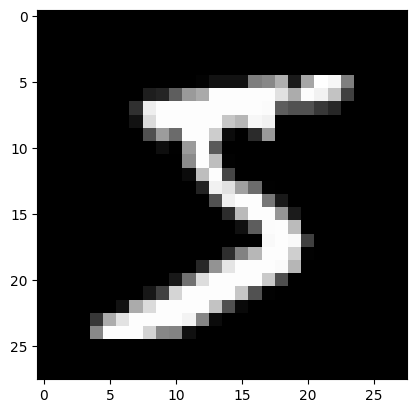

In [7]:
print(torch.FloatTensor(x_train_py)[0])
plt.imshow(x_train_py[0], cmap='grey')
plt.show()

Przeskalowaliśmy dane do zakresu od 0 do 1

# Załadowanie danych 

In [8]:
from torch.utils.data import DataLoader, TensorDataset

os.makedirs("./data", exist_ok=True)

#Normalizacja
mean = 0.1307
std = 0.3081
x_train_py = (x_train_py - mean) / std
x_test_py = (x_test_py - mean) / std

torch.save((x_train_py, y_train_py), "./data/train_dataset.pt")
torch.save((x_test_py, y_test_py), "./data/test_dataset.pt")

train_dataset = TensorDataset(x_train_py, y_train_py)
test_dataset = TensorDataset(x_test_py, y_test_py)

val_size = 5000
train_size = len(train_dataset) - val_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128 # można zmienić na mniejszy - jeśli nie będzie działać (out of memory error), to TRZEBA zmienić na mniejszy (16,32,64)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_dataset)

(55000, 5000, 10000)

# Baseline 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseLine(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, num_classes = 10):
        super(BaseLine, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # print(f"Wejście: {x.shape}")
        x = self.flatten(x) 
        # print(f"Po spłaszczeniu: {x.shape}")
        x = self.fc1(x)
        # print(f"Po fc1: {x.shape}")
        x = self.fc2(x)
        # print(f"Wyjście: {x.shape}")
        return x
    
model = BaseLine().to(device)

# sample_input = torch.randn(1, 1, 28, 28).to(device)
# output_tensor = model(sample_input) 



- wejscie (1, 28, 28)
- po spłaszczeniu (1, 784)
- po fc1 (1, 128)
- wyjscie (1, 10)

In [10]:
EPOCHS = 5
lr = 1e-3

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)  
        if train:
            optimizer.zero_grad()
            
            logits = model(xb)
            loss = criterion(logits, yb)
            
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(xb)
                loss = criterion(logits, yb)
        
        # Zbieranie statystyk
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    
    return epoch_loss / total, correct / total


history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {train_loss:.4f} acc {train_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}")
    
print(f"Czas treningu: {time.time()-start:.1f}s")

/home/fidok/.pyenv/versions/mnist-env/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX 1060 6GB which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
    
  warnings.warn(
/home/fidok/.pyenv/versions/mnist-env/lib/python3.12/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/home/fidok/.pyenv/versions/mnist-env/lib/python3.12/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce GTX 1060 6GB with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_70 sm_75 sm_80 sm_86 sm_90 sm_100 sm_120.
If you want to use the NVIDIA GeForce GTX 1060 6GB GPU 

Ep 01/5 | train loss 1.6867 acc 0.5577 | val loss 1.2229 acc 0.7522
Ep 02/5 | train loss 1.0163 acc 0.7858 | val loss 0.8498 acc 0.8120
Ep 03/5 | train loss 0.7652 acc 0.8282 | val loss 0.6879 acc 0.8364
Ep 04/5 | train loss 0.6426 acc 0.8492 | val loss 0.5991 acc 0.8510
Ep 05/5 | train loss 0.5704 acc 0.8604 | val loss 0.5434 acc 0.8590
Czas treningu: 27.6s


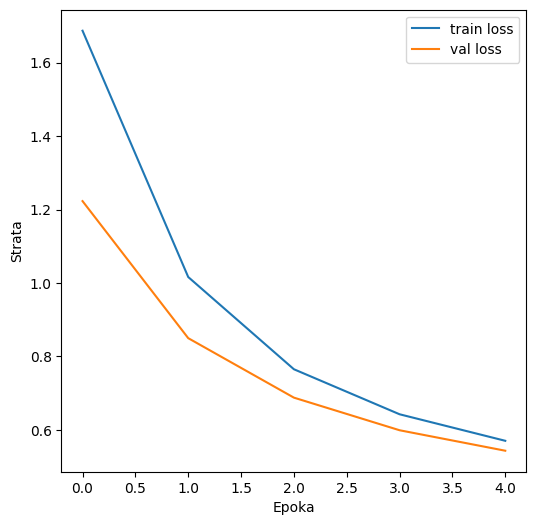

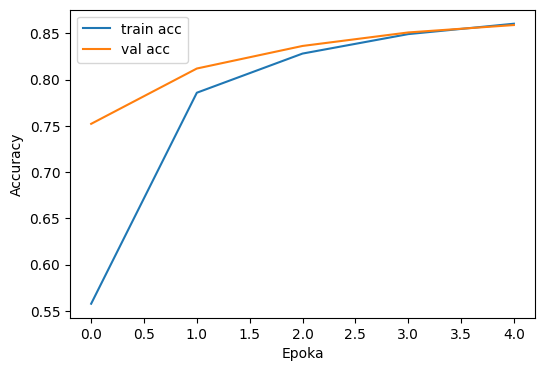

In [11]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Wyniki dla zbioru treningowego i zbioru walidacyjnego, bez dostosowywania jeszcze parametrów tego modelu.
<br>
Śledzimy:
- train loss - pokazuje jak model dobrze dopasowywuje się do dancyh
- accuracy - procent poprawnych przewidywań modelu

val loss: 0.5434, val accuracy: 0.8590


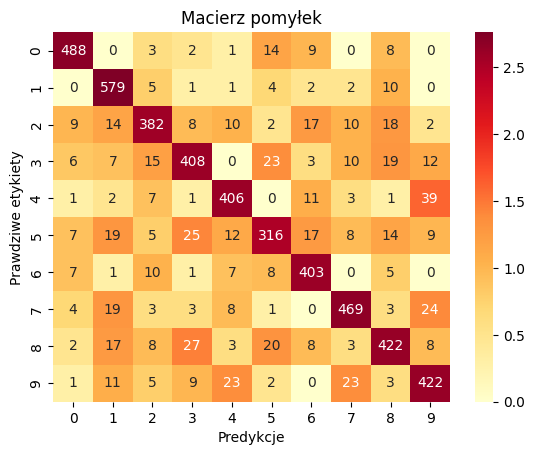

In [12]:
import seaborn as sns

def get_all_preds_labels(loader, model):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(yb.numpy())
    return np.array(all_labels), np.array(all_preds)

val_loss, test_acc = run_epoch(val_loader, train=False)
print(f"val loss: {val_loss:.4f}, val accuracy: {val_acc:.4f}")

y_true, y_pred = get_all_preds_labels(val_loader, model)

cm = confusion_matrix(y_true, y_pred)
cm_log = np.log10(cm + 1)
    
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="YlOrRd")
    
plt.xlabel("Predykcje")
plt.ylabel("Prawdziwe etykiety")
plt.title("Macierz pomyłek")
plt.show()

Analizujemy macierz pomyłek i podane statystki, aby wiedzieć z czym nasz model sobie najgorzej radzi
<br>
Widać tutaj że najlepiej rozpoznaje cyfrę 1
<br>
Najczęściej myli 4 z 9 i na odwrót, oraz ma problemy z cyfrą 3 

# Poprawiamy model

In [13]:
from torch.optim import Adam

class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Utwórz nowy model i optymalizator
model = ImprovedNet().to(device)
optimizer = Adam(model.parameters(), lr=lr)

kopiujemy kod bo, aby było wsztstko po kolei

In [15]:
EPOCHS = 5
lr = 1e-3

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)  
        if train:
            optimizer.zero_grad()
            
            logits = model(xb)
            loss = criterion(logits, yb)
            
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(xb)
                loss = criterion(logits, yb)
        
        # Zbieranie statystyk
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    
    return epoch_loss / total, correct / total


history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {train_loss:.4f} acc {train_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}")
    
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.6458 acc 0.8601 | val loss 0.5556 acc 0.8806
Ep 02/5 | train loss 0.5836 acc 0.8703 | val loss 0.5044 acc 0.8876
Ep 03/5 | train loss 0.5357 acc 0.8777 | val loss 0.4663 acc 0.8914
Ep 04/5 | train loss 0.4970 acc 0.8837 | val loss 0.4311 acc 0.8986
Ep 05/5 | train loss 0.4675 acc 0.8885 | val loss 0.4039 acc 0.9022
Czas treningu: 68.0s


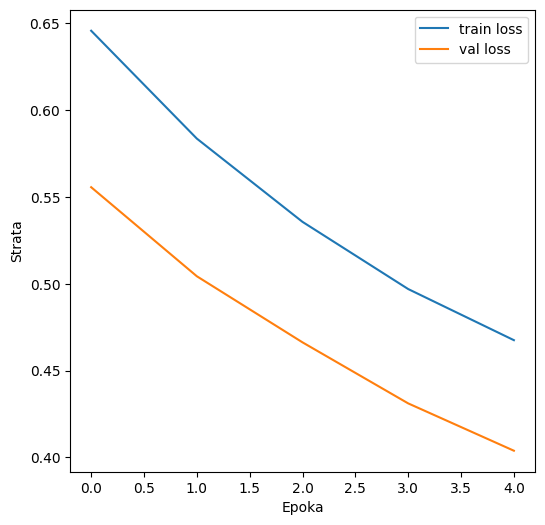

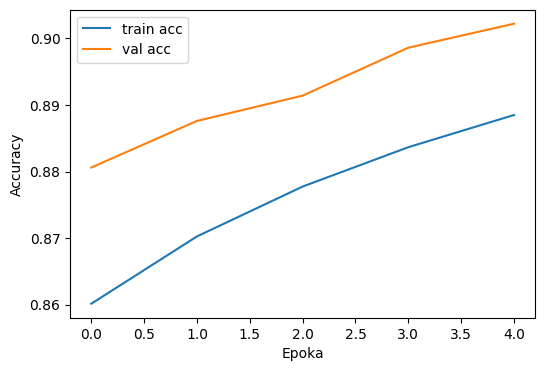

In [16]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Jest lepeij, pomyślmy co jeszcze można zrobić 

val loss: 0.4039, val accuracy: 0.9022


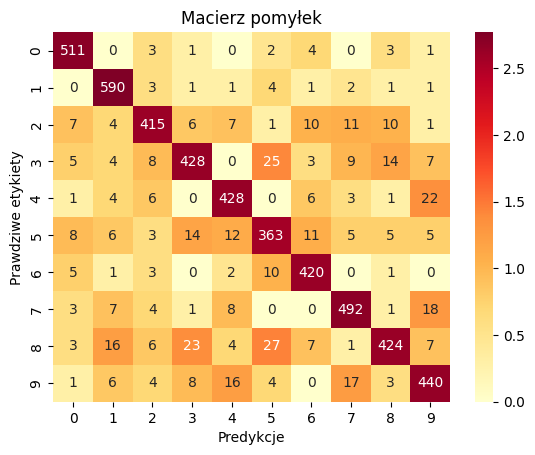

In [17]:
val_loss, test_acc = run_epoch(val_loader, train=False)
print(f"val loss: {val_loss:.4f}, val accuracy: {val_acc:.4f}")

y_true, y_pred = get_all_preds_labels(val_loader, model)

cm = confusion_matrix(y_true, y_pred)
cm_log = np.log10(cm + 1)
    
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="YlOrRd")
    
plt.xlabel("Predykcje")
plt.ylabel("Prawdziwe etykiety")
plt.title("Macierz pomyłek")
plt.show()

Już prawie jeszcze trochę i będzie dobrze, jak zwykle 9 z 4 pomylił i 8 z 3

In [18]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNNet().to(device)

mamy tutaj:
- 2 kanały w warstwie konwolucji 3x3
- pool zmniejsz rozmiar o polowę
- full conected 1 i 2 
- dropout 0.5 połowa neukornów umiera aby się nie przeuczyć
- bn1/2 noramalizuje aktywację 
- relu to po prostu relu było na wykładzie

In [19]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Transformacja obrazu/ nadanie sztócznej różnorodności obrazów

Ep 01/10 | train loss 0.0986 acc 0.9707 | val loss 0.0402 acc 0.9894
Ep 02/10 | train loss 0.0731 acc 0.9777 | val loss 0.0423 acc 0.9878
Ep 03/10 | train loss 0.0640 acc 0.9808 | val loss 0.0475 acc 0.9864
Ep 04/10 | train loss 0.0529 acc 0.9838 | val loss 0.0447 acc 0.9864
Ep 05/10 | train loss 0.0497 acc 0.9850 | val loss 0.0472 acc 0.9882
Ep 06/10 | train loss 0.0438 acc 0.9859 | val loss 0.0407 acc 0.9890
Ep 07/10 | train loss 0.0394 acc 0.9873 | val loss 0.0379 acc 0.9902
Ep 08/10 | train loss 0.0370 acc 0.9887 | val loss 0.0409 acc 0.9906
Ep 09/10 | train loss 0.0323 acc 0.9901 | val loss 0.0384 acc 0.9892
Ep 10/10 | train loss 0.0301 acc 0.9901 | val loss 0.0383 acc 0.9898

Czas treningu: 490.9s
Najlepsza walidacyjna accuracy: 0.9906


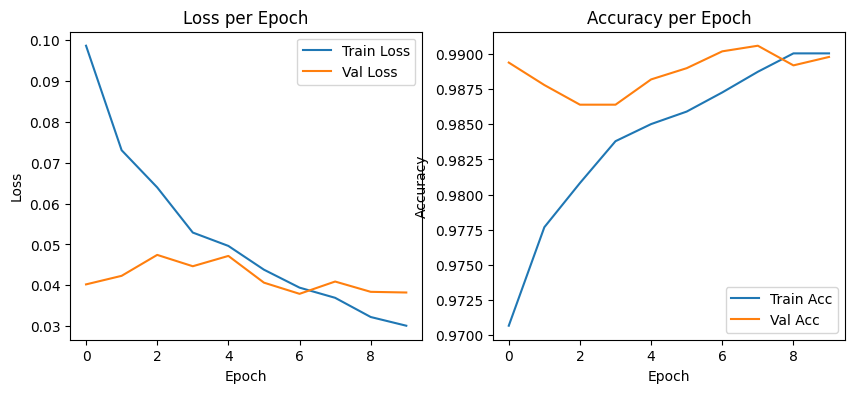

In [26]:
import copy

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

EPOCHS = 10
lr = 1e-3
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

def run_epoch(loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()

    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        if xb.dim() == 3:
            xb = xb.unsqueeze(1)
        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)

            if train:
                loss.backward()
                optimizer.step()

        # Statystyki
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    avg_loss = epoch_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc

start = time.time()
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Zapisywanie najlepszego modelu
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(
        f"Ep {epoch:02d}/{EPOCHS} "
        f"| train loss {train_loss:.4f} acc {train_acc:.4f} "
        f"| val loss {val_loss:.4f} acc {val_acc:.4f}"
    )

print(f"\nCzas treningu: {time.time() - start:.1f}s")
print(f"Najlepsza walidacyjna accuracy: {best_val_acc:.4f}")

# Załaduj najlepsze wagi
model.load_state_dict(best_model_wts)

# --- WYKRESY ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss per Epoch")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy per Epoch")

plt.show()

No i mamy 0.9906 accuracy na dymanym CPU bo Pytorch ma problemy do mojego GPU

Model dobrze się uczy, brak gwałtownego wzrostu (brak overfitingu), co do accuracy to model się dobrze uczy brak przeuczenia linie się schodzą

Teraz można sprawdzić jak zbiór testowy poradzi sobie

In [33]:
test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"\nWyniki na zbiorze testowym:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Wyniki na zbiorze testowym:
Test Loss: 0.0270
Test Accuracy: 0.9926


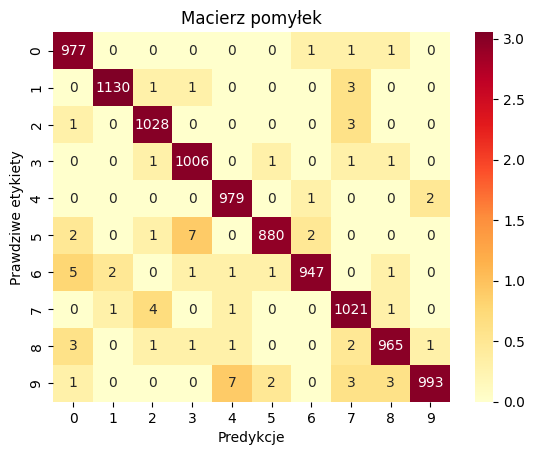

In [36]:

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        if xb.dim() == 3:
            xb = xb.unsqueeze(1)  # Add channel dimension if missing
        logits = model(xb)
        preds = logits.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Macierz pomyłek
cm = confusion_matrix(all_labels, all_preds)
cm_log = np.log10(cm + 1)
    
sns.heatmap(cm_log, annot=cm, fmt="d", cmap="YlOrRd")
    
plt.xlabel("Predykcje")
plt.ylabel("Prawdziwe etykiety")
plt.title("Macierz pomyłek")
plt.show()


In [ ]:
save_path = ".data/mnist_cnn.pt"
torch.save(model.state_dict(), save_path)
print(f"Model zapisany do: {os.path.abspath(save_path)}")

Model zapisany do: /home/fidok/Projects/WakacyjneWyzwanieSOLVRO_ML/ml-wakacyjne-wyzwanie-2025/3_nn&cv/mnist_cnn.pt


# Wioski

0.9926 jest dobrze, ale nie idalnie mogło być lepiej, można pomyśleć jeszcze nad dodaniem większej ilości warstw jkoknwolucyjnych, zwiększeniem liczby filtrów, czy użyciem innych architektur. Można oczywiście przejśc z 10 epok na 20 i sprawdzić co się stanie, ale nie chcę mi się czekać aż łaskawie moje cpu to obliczy. Można również pobawić się w transformowanie zdjęć czy inne parametry, ale to już przy większych projektach. Najtrudniejsze w tym zdaniau dla mnie nie było stworzenie modelu, bo to było jasno i klarownie wyjaśnione w notebooku, ale przejście z danych zebranych z tensorflowa na dane do pytorcha, tak aby odpowiednio się zpaisały. 